**2장 – 머신러닝 프로젝트 처음부터 끝까지**

*머신러닝 부동산 회사에 오신 것을 환영합니다! 여러분이 할 작업은 캘리포니아 지역 주택의 여러 특성을 사용해 중간 가격을 예측하는 것입니다.*

*이 노트북은 2장의 모든 샘플 코드와 연습 문제 정답을 담고 있습니다.*

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/rickiepark/handson-ml2/blob/master/02_end_to_end_machine_learning_project.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />구글 코랩에서 실행하기</a>
  </td>
</table>

# 설정

먼저 몇 개의 모듈을 임포트합니다. 맷플롯립 그래프를 인라인으로 출력하도록 만들고 그림을 저장하는 함수를 준비합니다. 또한 파이썬 버전이 3.5 이상인지 확인합니다(파이썬 2.x에서도 동작하지만 곧 지원이 중단되므로 파이썬 3을 사용하는 것이 좋습니다). 사이킷런 버전이 0.20 이상인지도 확인합니다.

In [28]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 깔금한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "end_to_end_project"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장:", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 불필요한 경고를 무시합니다 (사이파이 이슈 #5998 참조)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# 데이터 가져오기

In [29]:
import os
import tarfile
import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/rickiepark/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [30]:
fetch_housing_data()

In [31]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [32]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [33]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [34]:
housing["ocean_proximity"].value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

In [35]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


그림 저장: attribute_histogram_plots


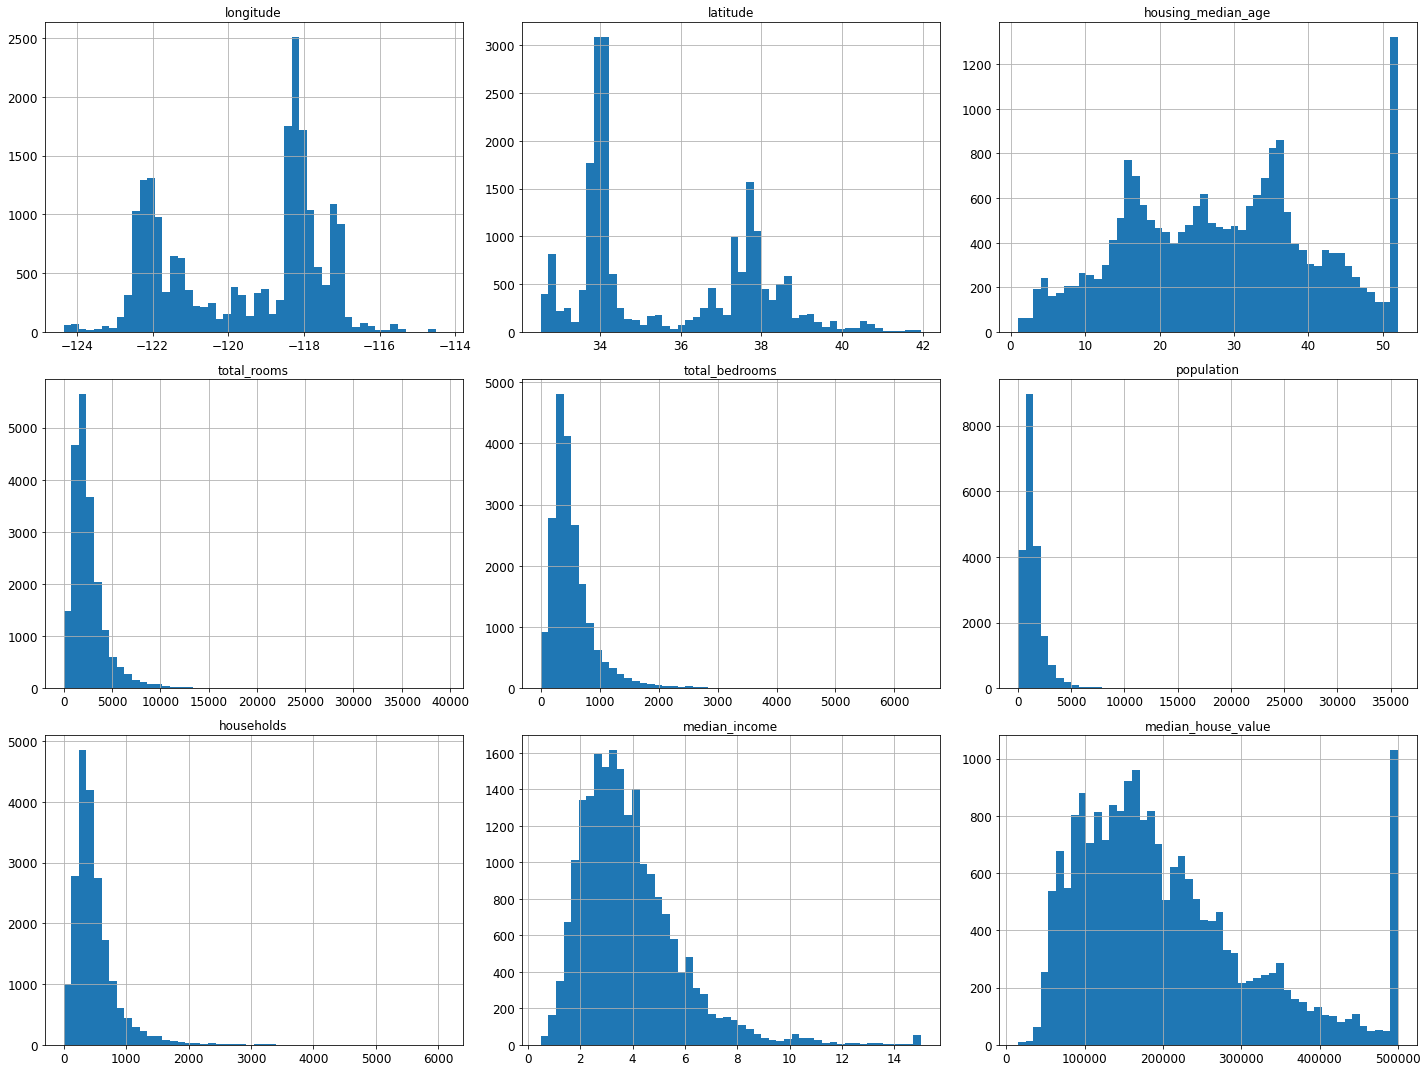

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
save_fig("attribute_histogram_plots")
plt.show()

In [37]:
# 노트북의 실행 결과가 동일하도록
np.random.seed(42)

In [38]:
import numpy as np

# 예시로 만든 것입니다. 실전에서는 사이킷런의 train_test_split()를 사용하세요.
def split_train_test(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [39]:
train_set, test_set = split_train_test(housing, 0.2)
len(train_set)

16512

In [40]:
len(test_set)

4128

In [41]:
from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

위의 `test_set_check()` 함수가 파이썬 2와 파이썬 3에서 모두 잘 동작합니다. 초판에서는 모든 해시 함수를 지원하는 다음 방식을 제안했지만 느리고 파이썬 2를 지원하지 않습니다.

In [42]:
import hashlib

def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return hash(np.int64(identifier)).digest()[-1] < 256 * test_ratio

모든 해시 함수를 지원하고 파이썬 2와 파이썬 3에서 사용할 수 있는 함수를 원한다면 다음을 사용하세요.

In [43]:
def test_set_check(identifier, test_ratio, hash=hashlib.md5):
    return bytearray(hash(np.int64(identifier)).digest())[-1] < 256 * test_ratio

In [44]:
housing_with_id = housing.reset_index()   # `index` 열이 추가된 데이터프레임을 반환합니다
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "index")

In [45]:
housing_with_id["id"] = housing["longitude"] * 1000 + housing["latitude"]
train_set, test_set = split_train_test_by_id(housing_with_id, 0.2, "id")

In [46]:
test_set.head()

,index,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,id
8,8,-122.26,37.84,42.0,2555.0,665.0,1206.0,595.0,2.0804,226700.0,NEAR BAY,-122222.16
10,10,-122.26,37.85,52.0,2202.0,434.0,910.0,402.0,3.2031,281500.0,NEAR BAY,-122222.15
11,11,-122.26,37.85,52.0,3503.0,752.0,1504.0,734.0,3.2705,241800.0,NEAR BAY,-122222.15
12,12,-122.26,37.85,52.0,2491.0,474.0,1098.0,468.0,3.0750,213500.0,NEAR BAY,-122222.15
13,13,-122.26,37.84,52.0,696.0,191.0,345.0,174.0,2.6736,191300.0,NEAR BAY,-122222.16


In [47]:
from sklearn.model_selection import train_test_split

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

In [48]:
test_set.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
20046,-119.01,36.06,25.0,1505.0,NaN,1392.0,359.0,1.6812,47700.0,INLAND
3024,-119.46,35.14,30.0,2943.0,NaN,1565.0,584.0,2.5313,45800.0,INLAND
15663,-122.44,37.80,52.0,3830.0,NaN,1310.0,963.0,3.4801,500001.0,NEAR BAY
20484,-118.72,34.28,17.0,3051.0,NaN,1705.0,495.0,5.7376,218600.0,<1H OCEAN
9814,-121.93,36.62,34.0,2351.0,NaN,1063.0,428.0,3.7250,278000.0,NEAR OCEAN


<AxesSubplot:>

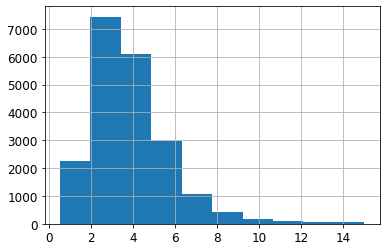

In [49]:
housing["median_income"].hist()

In [50]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

In [51]:
housing["income_cat"].value_counts()

3    7236
2    6581
4    3639
5    2362
1     822
Name: income_cat, dtype: int64

<AxesSubplot:>

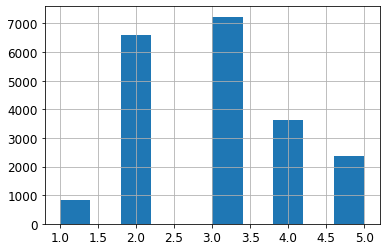

In [52]:
housing["income_cat"].hist()

In [53]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [54]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [56]:
def income_cat_proportions(data):
    return data["income_cat"].value_counts() / len(data)

train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

compare_props = pd.DataFrame({
    "Overall": income_cat_proportions(housing),
    "Stratified": income_cat_proportions(strat_test_set),
    "Random": income_cat_proportions(test_set),
}).sort_index()
compare_props["Rand. %error"] = 100 * compare_props["Random"] / compare_props["Overall"] - 100
compare_props["Strat. %error"] = 100 * compare_props["Stratified"] / compare_props["Overall"] - 100

# 데이터 이해를 위한 탐색과 시각화

In [57]:
# Download the California image
images_path = os.path.join(PROJECT_ROOT_DIR, "images", "end_to_end_project")
os.makedirs(images_path, exist_ok=True)
DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
filename = "california.png"
print("Downloading", filename)
url = DOWNLOAD_ROOT + "images/end_to_end_project/" + filename
urllib.request.urlretrieve(url, os.path.join(images_path, filename))

('.\\images\\end_to_end_project\\california.png',
 <http.client.HTTPMessage at 0x225f77a3220>)

그림 저장: california_housing_prices_plot


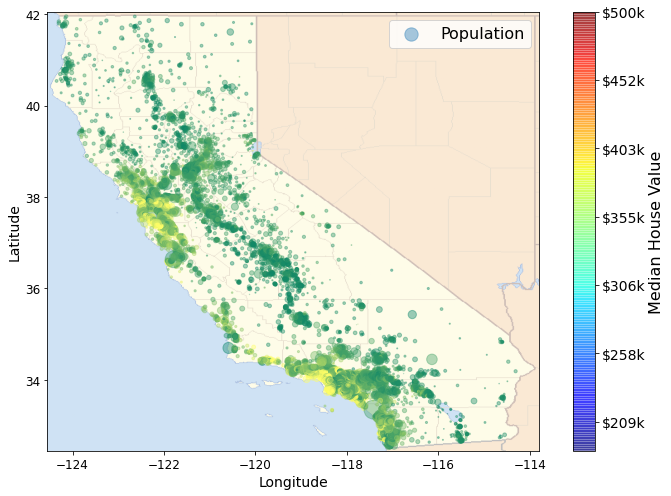

In [58]:
import matplotlib.image as mpimg
california_img=mpimg.imread(os.path.join(images_path, filename))
ax = housing.plot(kind="scatter", x="longitude", y="latitude", figsize=(10,7),
                       s=housing['population']/100, label="Population",
                       c="median_house_value", cmap=plt.get_cmap("summer"),
                       colorbar=False, alpha=0.4,
                      )
plt.imshow(california_img, extent=[-124.55, -113.80, 32.45, 42.05], alpha=0.5,
           cmap=plt.get_cmap("jet"))
plt.ylabel("Latitude", fontsize=14)
plt.xlabel("Longitude", fontsize=14)

prices = housing["median_house_value"]
tick_values = np.linspace(prices.min(), prices.max(), 11)
cbar = plt.colorbar(ticks=tick_values/prices.max())
cbar.ax.set_yticklabels(["$%dk"%(round(v/1000)) for v in tick_values], fontsize=14)
cbar.set_label('Median House Value', fontsize=16)

plt.legend(fontsize=16)
save_fig("california_housing_prices_plot")
plt.show()

In [59]:
# from pandas.tools.plotting import scatter_matrix # 옛날 버전의 판다스에서는 
from pandas.plotting import scatter_matrix ## 상관관계

attributes = ["median_house_value", "median_income", "total_rooms",
              "housing_median_age"]

In [60]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

## 변수간의 다중공산성 문제를 제거하기 위해 사용
## 딥러닝에서는 사용
## 머신러닝에서는 사용하지만 딥러닝은 따로 사용하지 않는다. 

# 머신러닝 알고리즘을 위한 데이터 준비

In [61]:
housing

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat,rooms_per_household,bedrooms_per_room,population_per_household
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5,6.984127,0.146591,2.555556
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5,6.238137,0.155797,2.109842
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5,8.288136,0.129516,2.802260
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4,5.817352,0.184458,2.547945
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3,6.281853,0.172096,2.181467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND,2,5.045455,0.224625,2.560606
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND,2,6.114035,0.215208,3.122807
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND,2,5.205543,0.215173,2.325635
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND,2,5.329513,0.219892,2.123209


In [62]:
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="median")

In [63]:
housing_num = housing.drop("ocean_proximity",axis = 1)

In [64]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [65]:
imputer.statistics_

array([-1.18490000e+02,  3.42600000e+01,  2.90000000e+01,  2.12700000e+03,
        4.35000000e+02,  1.16600000e+03,  4.09000000e+02,  3.53480000e+00,
        1.79700000e+05,  3.00000000e+00,  5.22912879e+00,  2.03162434e-01,
        2.81811565e+00])

In [66]:
housing_num.median().values

array([-1.18490000e+02,  3.42600000e+01,  2.90000000e+01,  2.12700000e+03,
        4.35000000e+02,  1.16600000e+03,  4.09000000e+02,  3.53480000e+00,
        1.79700000e+05,  5.22912879e+00,  2.03162434e-01,  2.81811565e+00])

In [68]:
X = imputer.transform(housing_num)
housing_tr =pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [69]:
housing_tr

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,income_cat,rooms_per_household,bedrooms_per_room,population_per_household
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,5.0,6.984127,0.146591,2.555556
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,5.0,6.238137,0.155797,2.109842
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,5.0,8.288136,0.129516,2.802260
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,4.0,5.817352,0.184458,2.547945
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,3.0,6.281853,0.172096,2.181467
...,...,...,...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,2.0,5.045455,0.224625,2.560606
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,2.0,6.114035,0.215208,3.122807
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,2.0,5.205543,0.215173,2.325635
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,2.0,5.329513,0.219892,2.123209


In [71]:
housing_cat = housing[['ocean_proximity']]
housing_cat.head(10)

,ocean_proximity
0,NEAR BAY
1,NEAR BAY
2,NEAR BAY
3,NEAR BAY
4,NEAR BAY
5,NEAR BAY
6,NEAR BAY
7,NEAR BAY
8,NEAR BAY
9,NEAR BAY


In [72]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:5]

array([[3.],
       [3.],
       [3.],
       [3.],
       [3.]])

In [73]:
ordinal_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [77]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder(sparse=False)  # sparse 의 경우 toarray 를 안해도 된다.
# 결과값이 sparse matrix 형태로 출력이 되기때문에 False 로 해서 하기
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [76]:
# housing_cat_1hot.toarray()  ## toarray() 로 하면 보통 해결이 잘되더라...

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [78]:
from sklearn.base import BaseEstimator, TransformerMixin

# 열 인덱스
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # *args 또는 **kargs 없음
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # 아무것도 하지 않습니다
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.to_numpy())

In [80]:
housing_extra_attribs = pd.DataFrame(housing_extra_attribs,columns=list(housing.columns) + ["rooms_per_household","population_per_household"],index= housing.index)
housing_extra_attribs.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat,rooms_per_household,bedrooms_per_room,population_per_household,rooms_per_household,population_per_household
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5,6.984127,0.146591,2.555556,6.984127,2.555556
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5,6.238137,0.155797,2.109842,6.238137,2.109842
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5,8.288136,0.129516,2.80226,8.288136,2.80226
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4,5.817352,0.184458,2.547945,5.817352,2.547945
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3,6.281853,0.172096,2.181467,6.281853,2.181467


In [81]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

In [82]:
from sklearn.base import BaseEstimator, TransformerMixin

# 수치형 열과 범주형 열을 선택하기 위한 클래스
class OldDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [83]:
num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

old_num_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(num_attribs)),
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

old_cat_pipeline = Pipeline([
        ('selector', OldDataFrameSelector(cat_attribs)),
        ('cat_encoder', OneHotEncoder(sparse=False)),
    ])

In [84]:
from sklearn.pipeline import FeatureUnion

old_full_pipeline = FeatureUnion(transformer_list=[
        ("num_pipeline", old_num_pipeline),
        ("cat_pipeline", old_cat_pipeline),
    ])



In [86]:
old_housing_prepared = old_full_pipeline.fit_transform(housing)
old_housing_prepared

array([[-1.32783522,  1.05254828,  0.98214266, ...,  0.        ,
         1.        ,  0.        ],
       [-1.32284391,  1.04318455, -0.60701891, ...,  0.        ,
         1.        ,  0.        ],
       [-1.33282653,  1.03850269,  1.85618152, ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.8237132 ,  1.77823747, -0.92485123, ...,  0.        ,
         0.        ,  0.        ],
       [-0.87362627,  1.77823747, -0.84539315, ...,  0.        ,
         0.        ,  0.        ],
       [-0.83369581,  1.75014627, -1.00430931, ...,  0.        ,
         0.        ,  0.        ]])

In [87]:
housing_prepared = old_housing_prepared

# 모델 선택과 훈련

In [ ]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

In [ ]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared,housing_labels)

# 모델 세부 튜닝

In [ ]:
def display_scores(scores):
    print("점수:", scores)
    print("평균:", scores.mean())
    print("표준 편차:", scores.std())

**노트**: 사이킷런 0.22 버전에서 `n_estimators`의 기본값이 100으로 바뀌기 때문에 향후를 위해 `n_estimators=100`로 지정합니다(책에는 등장하지 않습니다).

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # 12(=3×4)개의 하이퍼파라미터 조합을 시도합니다.
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # bootstrap은 False로 하고 6(=2×3)개의 조합을 시도합니다.
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

# 추가 내용

## 전처리와 예측을 포함한 전체 파이프라인

In [ ]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("linear", LinearRegression())
    ])

full_pipeline_with_predictor.fit(housing, housing_labels)
full_pipeline_with_predictor.predict(some_data)

## joblib를 사용한 모델 저장

In [ ]:
my_model = full_pipeline_with_predictor

In [ ]:
import joblib
joblib.dump(my_model, "my_model.pkl") # DIFF
#...
my_model_loaded = joblib.load("my_model.pkl") # DIFF

## `RandomizedSearchCV`를 위한 Scipy 분포 함수

In [ ]:
from scipy.stats import geom, expon
geom_distrib=geom(0.5).rvs(10000, random_state=42)
expon_distrib=expon(scale=1).rvs(10000, random_state=42)
plt.hist(geom_distrib, bins=50)
plt.show()
plt.hist(expon_distrib, bins=50)
plt.show()